### Evaluate maximum CCD temperature for anneal

For the anneal pathfinder, we defined parameters of the test via previous experience:

 * At -19 C we are comfortable with a 10.3 mag guide star.
 * At +20 C the dark current scales up by a factor of about 32 from the -19 C value. This is based on our best calibration.
 * Using the manufacturer spec indicates a factor more like 45 (based on a factor of 120 increase from 250 K to 300 K).
 * The 6th brightest star in the Pleiades is 4.8 mag (ACA) = 10.3 - 5.5 mags => factor of 150 brighter than 10.3. We can tolerate an increase by a factor of 150 in dark current.
 
While being able to tolerate a factor of 150, we set a conservative limit of 100 as the scale factor limit.  The scale at +8 was seen to scale by more than originally estimated before the annealing pathfinder.  Below, we've improved the calibration of the scale change by refitting the scale factor using the available data from the annealing pathfinder.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.ndimage.filters import median_filter
import numpy as np
import matplotlib.pyplot as plt
from sherpa import ui
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate

from mica.archive import aca_hdr3
from mica.archive import aca_l0
from mica.archive.aca_dark.dark_cal import dark_temp_scale

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


These routines were used during the pathfinder to do quick fits of the e-/sec data.

In [3]:
T_CCD_REF = -19 # Reference temperature for dark current values in degC          
def dark_scale_model(pars, t_ccd):
    """                                                                          
    dark_t_ref : dark current of a pixel at the reference temperature            
    scale : dark current model scale factor                                      
    returns : dark_t_ref scaled to the observed temperatures t_ccd               
    """
    scale, dark_t_ref = pars
    scaled_dark_t_ref = dark_t_ref * np.exp(np.log(scale) / 4.0 * (T_CCD_REF - t_ccd))
    return scaled_dark_t_ref

def fit_pix_values(t_ccd, esec, id=1):
    data_id = id
    ui.set_method('simplex')
    ui.load_user_model(dark_scale_model, 'model')
    ui.add_user_pars('model', ['scale', 'dark_t_ref'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id,
                   np.array(t_ccd),
                   np.array(esec))
    d = ui.get_data(id)
    d.staterror = 30 * np.ones(len(t_ccd))
    model.scale.val = 0.70
    model.dark_t_ref.val = 500
    ui.freeze(model.scale)
    # If more than 5 degrees in the temperature range,                           
    # thaw and fit for model.scale.  Else just use/return                        
    # the fit of dark_t_ref                                                      
    if np.max(t_ccd) - np.min(t_ccd) > 2:
        # Fit first for dark_t_ref                                               
        ui.fit(data_id)
        ui.thaw(model.scale)
    ui.fit(data_id)
    return ui.get_fit_results(), ui.get_model(data_id)

Get the data for the interval from the monitor window slots.

In [4]:
start = '2015:252:13:00:00.000'
stop = '2015:252:16:00:00.000'
GAIN = 5.0
ccd_temp = aca_hdr3.MSID('ccd_temp', start, stop)
slot6 = aca_l0.get_slot_data(start, stop, 6)
slot7 = aca_l0.get_slot_data(start, stop, 7)

Run the fits on all pixel with a max median filtered e-/sec count >= 2000

In [5]:
THRESH = 2000
fits = {}
for slot in [slot6, slot7]:
    ok = (slot['TEMPCCD'] - 273.15) > -13
    slot = slot[ok]
    t_ccd = slot['TEMPCCD'] - 273.15
    for i_col in range(0, 64):
        esec = slot['IMGRAW'][:, i_col] * GAIN / slot['INTEG']
        medf_esec = median_filter(esec, 5)
        if np.max(medf_esec) < THRESH:
            continue
        slot_num = slot['IMGNUM1'][0]
        fit_id = 100 * slot_num + i_col
        print "slot {} pix idx {}".format(slot_num,
                                          i_col)
        fit, modpars  = fit_pix_values(t_ccd,
                                       esec,
                                       id=fit_id)
        fits[fit_id] = {'fit': fit,
                        'modpars': modpars,
                        'esec': esec,
                        't_ccd': t_ccd.copy(),
                        'dt': slot['TIME'] - DateTime(start).secs,
                        't0': DateTime(start).secs}

slot 6 pix idx 46
Dataset               = 646
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 5.34439e+06
Final fit statistic   = 111779 at function evaluation 121
Data points           = 1499
Degrees of freedom    = 1498
Probability [Q-value] = 0
Reduced statistic     = 74.6189
Change in statistic   = 5.23261e+06
   model.dark_t_ref   167.091     


INFO:sherpa.ui.utils:Dataset               = 646
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 5.34439e+06
Final fit statistic   = 111779 at function evaluation 121
Data points           = 1499
Degrees of freedom    = 1498
Probability [Q-value] = 0
Reduced statistic     = 74.6189
Change in statistic   = 5.23261e+06
   model.dark_t_ref   167.091     


Dataset               = 646
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 111779
Final fit statistic   = 68112.4 at function evaluation 2039
Data points           = 1499
Degrees of freedom    = 1497
Probability [Q-value] = 0
Reduced statistic     = 45.4993
Change in statistic   = 43666.6
   model.scale    0.602463    
   model.dark_t_ref   71.6605     


/proj/sot/ska/arch/x86_64-linux_CentOS-5/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in log
INFO:sherpa.ui.utils:Dataset               = 646
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 111779
Final fit statistic   = 68112.4 at function evaluation 2039
Data points           = 1499
Degrees of freedom    = 1497
Probability [Q-value] = 0
Reduced statistic     = 45.4993
Change in statistic   = 43666.6
   model.scale    0.602463    
   model.dark_t_ref   71.6605     


slot 7 pix idx 18
Dataset               = 718
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 3.99963e+06
Final fit statistic   = 250154 at function evaluation 123
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 167.439
Change in statistic   = 3.74947e+06
   model.dark_t_ref   217.803     


INFO:sherpa.ui.utils:Dataset               = 718
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 3.99963e+06
Final fit statistic   = 250154 at function evaluation 123
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 167.439
Change in statistic   = 3.74947e+06
   model.dark_t_ref   217.803     


Dataset               = 718
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 250154
Final fit statistic   = 150650 at function evaluation 2038
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 100.904
Change in statistic   = 99504.3
   model.scale    0.581228    
   model.dark_t_ref   75.7782     


INFO:sherpa.ui.utils:Dataset               = 718
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 250154
Final fit statistic   = 150650 at function evaluation 2038
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 100.904
Change in statistic   = 99504.3
   model.scale    0.581228    
   model.dark_t_ref   75.7782     


slot 7 pix idx 25
Dataset               = 725
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 6.00977e+06
Final fit statistic   = 259045 at function evaluation 117
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 173.391
Change in statistic   = 5.75072e+06
   model.dark_t_ref   150.522     


INFO:sherpa.ui.utils:Dataset               = 725
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 6.00977e+06
Final fit statistic   = 259045 at function evaluation 117
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 173.391
Change in statistic   = 5.75072e+06
   model.dark_t_ref   150.522     


Dataset               = 725
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 259045
Final fit statistic   = 152742 at function evaluation 355
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 102.306
Change in statistic   = 106303
   model.scale    0.528836    
   model.dark_t_ref   30.2629     


INFO:sherpa.ui.utils:Dataset               = 725
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 259045
Final fit statistic   = 152742 at function evaluation 355
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 102.306
Change in statistic   = 106303
   model.scale    0.528836    
   model.dark_t_ref   30.2629     


slot 7 pix idx 52
Dataset               = 752
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 5.08316e+06
Final fit statistic   = 136770 at function evaluation 118
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 91.5464
Change in statistic   = 4.94639e+06
   model.dark_t_ref   175.875     


INFO:sherpa.ui.utils:Dataset               = 752
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 5.08316e+06
Final fit statistic   = 136770 at function evaluation 118
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 91.5464
Change in statistic   = 4.94639e+06
   model.dark_t_ref   175.875     


Dataset               = 752
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 136770
Final fit statistic   = 63331.2 at function evaluation 329
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 42.4187
Change in statistic   = 73439.1
   model.scale    0.570965    
   model.dark_t_ref   55.1224     


INFO:sherpa.ui.utils:Dataset               = 752
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 136770
Final fit statistic   = 63331.2 at function evaluation 329
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 42.4187
Change in statistic   = 73439.1
   model.scale    0.570965    
   model.dark_t_ref   55.1224     


slot 7 pix idx 63
Dataset               = 763
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 4.07294e+06
Final fit statistic   = 135400 at function evaluation 115
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 90.6295
Change in statistic   = 3.93754e+06
   model.dark_t_ref   210.8       


INFO:sherpa.ui.utils:Dataset               = 763
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 4.07294e+06
Final fit statistic   = 135400 at function evaluation 115
Data points           = 1495
Degrees of freedom    = 1494
Probability [Q-value] = 0
Reduced statistic     = 90.6295
Change in statistic   = 3.93754e+06
   model.dark_t_ref   210.8       


Dataset               = 763
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 135400
Final fit statistic   = 62404.1 at function evaluation 2038
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 41.7978
Change in statistic   = 72996.3
   model.scale    0.595051    
   model.dark_t_ref   84.0303     


INFO:sherpa.ui.utils:Dataset               = 763
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 135400
Final fit statistic   = 62404.1 at function evaluation 2038
Data points           = 1495
Degrees of freedom    = 1493
Probability [Q-value] = 0
Reduced statistic     = 41.7978
Change in statistic   = 72996.3
   model.scale    0.595051    
   model.dark_t_ref   84.0303     


Plot the fits.

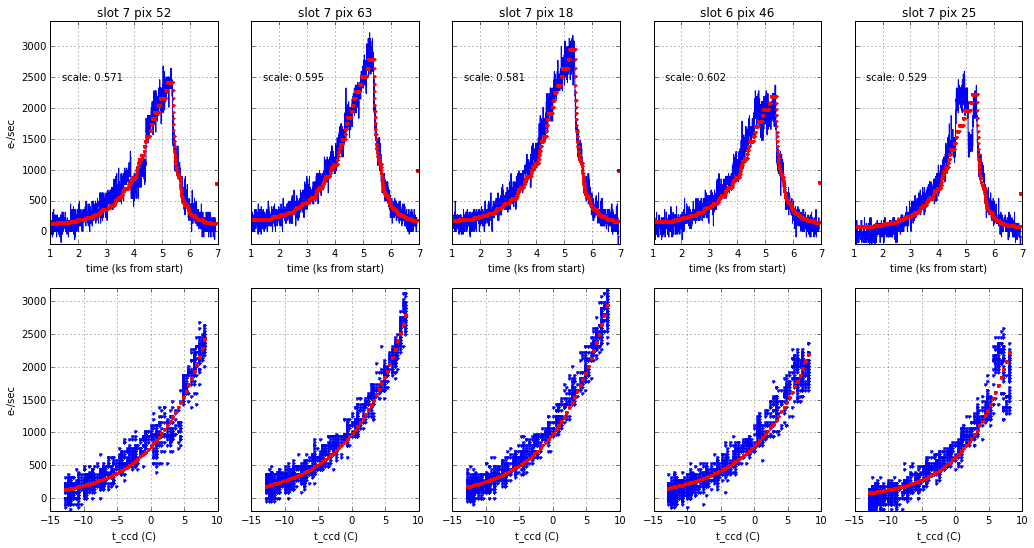

In [6]:
fig, fitaxes = plt.subplots(2, 5, figsize=(15, 8))
for i, fit_id in enumerate(fits):
    modplot = ui.get_model_plot(fit_id)

    timeax = fitaxes[0][i]
    fit = fits[fit_id]
    timeax.plot(fit['dt'] / 1000., fit['esec'], 'b')
    timeax.plot(fit['dt'] / 1000., modplot.y, 'r.')
    timeax.set_xlim(1, 7)
    timeax.set_ylim(-200, 3400)
    timeax.grid()
    timeax.set_xlabel('time (ks from start)')
    timeax.set_title("slot {} pix {}".format(fit_id / 100, fit_id - (fit_id / 100) * 100))
    timeax.annotate("scale: {:.3f}".format(fit['modpars'].scale.val),
                    xy=(0.25, 0.75), xycoords="axes fraction",
                    ha='center', va='center')
    if i > 0:
        timeax.set_yticklabels([])
    else:
        timeax.set_ylabel("e-/sec")
    fitax = fitaxes[1][i]
    fitax.plot(fit['t_ccd'], fit['esec'], 'b.')
    fitax.plot(modplot.x, modplot.y, 'r.')
    fitax.set_ylim(-200, 3200)
    fitax.grid()
    fitax.set_xlabel('t_ccd (C)')
    if i > 0:
        fitax.set_yticklabels([])
    else:
        fitax.set_ylabel("e-/sec")
fig.subplots_adjust(left=.05, bottom=.1, right=.95, top=.95, wspace=.2, hspace=.2)


In [7]:
# best / only good fits fits are slot 7 63 and slot 7 18                                          
best_fits = [763, 718]
scale = np.mean([fits[i]['modpars'].scale.val for i in best_fits])

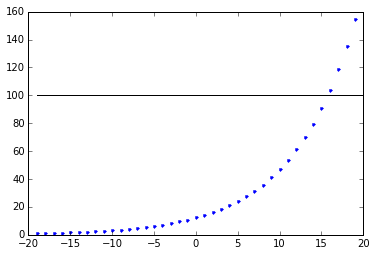

In [8]:
plot(np.arange(-19, 20), dark_temp_scale(-19, np.arange(-19, 20), scale_4c = 1.0 / scale), 'b.')
plot([-19, 20], [100, 100], 'k')


Maximum temperature, then, is 15.7 deg C to stay under the 100 overall scale limit.

In [9]:
dark_temp_scale(-19, 15.7, scale_4c = 1.0 / scale)

99.944060850868809